In [4]:
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt

In [5]:
# Activation functions
# Linear
def linear(z_input):
    return z_input

# Sigmoid
def sigmoid(z_input):
    return 1/(1+np.exp(-z_input))

# ReLU
def relu(z_input):
    return np.maximum(0, z_input)

# leaky ReLU
def leaky_relu(z_input, alpha = 0.01):
    return np.maximum(alpha*z_input, z_input)

# tanh
def tanh(z_input):
    return np.tanh(z_input)

In [6]:
# A loss function
def loss(y_hat, y):
    return ((y_hat - y)**2)

In [7]:
# Function to calculate the value of the derivative of a function at a given value
def der_fun(fun, x):
    h = 1e-5
    return (fun(x+h)-fun(x-h))/(2*h)

In [8]:
# A fancy loading bar function
def show_progress(i, iters, bar_len = 50):
    p = int(bar_len*((i+1)/(iters)))
    p_bar = '-'*p+'>'+'_'*(bar_len-(p))
    perc = round(((i+1)/(iters))*100, 2)
    print(f'{p_bar} {perc}%', end = '\r')

In [9]:
# A single neuron
class Neuron:
    
    # Initialise as a basic neuron with an activation function
    def __init__(self, act_func,
                 learn_rate = 0.01,
                 gradient_memory = 1,
                 gradient_clip = 1,
                 init_weight_scale = (-0.5, 0.5)):
        self.X = None
        self.W = None
        self.B = None
        self.nextgrad = None
        self.act_func = act_func
        self.learn_rate = learn_rate
        self.gradient_memory = gradient_memory
        self.gradient_clip = gradient_clip
        self.init_weight_scale = init_weight_scale
        self.Ws = []
        self.Bs = []
        self.Wgrads = {}
        self.Bgrads = []
        
    # Function to initiate weights and biases based on input
    def init_weights(self):
        self.W = np.random.default_rng().uniform(self.init_weight_scale[0],
                                                 self.init_weight_scale[1],
                                                 (self.X.shape[1], 1))
        #self.W = np.random.rand(1, self.X.shape[1]).T
        #self.W = np.random.randint(1, 10, (1, self.X.shape[1])).T
        #self.B = np.random.rand(1, 1)
        self.B = np.random.default_rng().uniform(self.init_weight_scale[0],
                                                 self.init_weight_scale[1],
                                                 (1, 1))
     
    # Function to generate a prediction
    def predict(self, X_input):
        return self.act_func(X_input.dot(self.W)+self.B)
        
    # Function to update weights and return derivative values
    def update_weights(self, d_prev):
        # Keep a memory of previous weights and biases
        self.Ws.append(self.W)
        self.Bs.append(self.B)
        # Get the derivative of the activation function
        d_act = der_fun(lambda z: self.act_func(z), self.X.dot(self.W)+self.B)
        # Update weights
        weights = []
        for n, weight in enumerate(self.W):
            d_w = der_fun(lambda w: self.X[:, n]*w+self.B, weight).T
            w_grad = d_prev*d_act*d_w
            if n in self.Wgrads:
                self.Wgrads[n].append(w_grad)
            else:
                self.Wgrads[n] = [w_grad]
            if len(self.Wgrads[n]) > self.gradient_memory:
                w_grad = sum(self.Wgrads[n][-self.gradient_memory:])/len(self.Wgrads[n][-self.gradient_memory:])
                self.Wgrads[n] = self.Wgrads[n][-self.gradient_memory:]
            else:
                w_grad = sum(self.Wgrads[n])/len(self.Wgrads[n])
            weight_update = [min(self.gradient_clip, sum(w_grad)) if sum(w_grad) >= 0 else max(-self.gradient_clip, sum(w_grad))][0]
            weights.append(weight-self.learn_rate*weight_update)
        # Update bias
        d_b = der_fun(lambda b: self.X.dot(self.W)+b, self.B)
        b_grad = d_prev*d_act*d_b
        self.Bgrads.append(b_grad)
        if len(self.Bgrads) > self.gradient_memory:
            b_grad = sum(self.Bgrads[-self.gradient_memory:])/len(self.Bgrads[-self.gradient_memory:])
            self.Bgrads = self.Bgrads[-self.gradient_memory:]
        else:
            b_grad = sum(self.Bgrads)/len(self.Bgrads)
        self.W = np.array(weights)
        b_update = [min(self.gradient_clip, sum(b_grad)) if sum(b_grad) >= 0 else max(-self.gradient_clip, sum(b_grad))][0]
        self.B = self.B-self.learn_rate*b_update
        # Store value of previous derivative times derivative of current activation function
        self.nextgrad = d_prev*d_act

In [10]:
# A fully connected neural network
class FCNN:
    # Initialise the network with values required by neurons
    def __init__(self, architecture, learn_rates, act_funcs,
                 nudge_limit, nudge_amount,
                 gradient_memories, gradient_clips,
                 init_weight_scales):
        '''
        architecture - Should be a list specifying the depth and width of the network, e.g., [1, 2, 2, 1].
        learn_rates - The learning rate applied to gradients in each layer, a list, e.g.,  [0.01, 0.01, 0.01, 0.01].
        act_funcs - A list of activation functions used by neurons in each layer, e.g., [relu, tanh, sigmoid, linear].
        nudge_limit - The minimum improvement on the results of the loss function during training, below which the nudge amount is applied to gradients.
        nudge_amount - The amount by which the gradient is multiplied if error isn't improving quickly enough. Set to 1 to disable.
        gradient_memories - A list specifying how far back neurons in each layer are to look for gradient momentum, e.g., [2, 2, 3, 5].
        gradient_clips - A list of values for neurons in each layer to bound their gradients during backpropagation, e.g., [1, 1, 1, 1]. np.inf will disable.
        init_weight_scales - A list of tuples for neurons in each layer to bound weight initialisation, e.g., [(0, 1), (-1, 1), (-0.5, 0.5), (0.1, 1)]
        '''
        self.architecture = architecture
        self.learn_rates = learn_rates
        self.act_funcs = act_funcs
        self.nudge_limit = nudge_limit
        self.nudge_amount = nudge_amount
        self.gradient_memories = gradient_memories
        self.gradient_clips = gradient_clips
        self.init_weight_scales = init_weight_scales
        self.layers = []
        self.yhs = []
        self.errs = []
        
    # Compile the network
    def compile_net(self, X):
        # Generate neurons based on the architecture specification
        for l, layer in enumerate(self.architecture):
            self.layers.append([Neuron(act_func = self.act_funcs[l],
                                       learn_rate = self.learn_rates[l],
                                       gradient_memory = self.gradient_memories[l],
                                       gradient_clip = self.gradient_clips[l],
                                       init_weight_scale = self.init_weight_scales[l]) for n in range(layer)])
        # Set inputs and initiate weights for neurons in all layers
        for m, layer in enumerate(self.layers):
            for neuron in layer:
                if m == 0:
                    neuron.X = X
                    neuron.init_weights()
                else:
                    if len(self.layers[m-1]) > 1:
                        neuron.X = np.array([n.predict(n.X) for n in self.layers[m-1]]).T.squeeze()
                    else:
                        neuron.X = np.array([n.predict(n.X) for n in self.layers[m-1]])[0,:,:]
                    neuron.init_weights()
                    
    # Train the network
    def train(self, epochs, Y):
        for e in range(epochs):
            show_progress(e, epochs)
            # Forward pass
            yh = np.array([n.predict(n.X) for n in self.layers[-1]])
            # Loss calculation
            err = [sum(loss(yh[z], Y)) for z in range(len(self.layers[-1]))]
            # Store values in model history
            self.yhs.append(yh)
            self.errs.append(err)
            # Update weights
            for n, layer in enumerate(self.layers[::-1]):
                for k, neuron in enumerate(layer):
                    if n == 0:
                        d_loss = der_fun(lambda a: loss(a, Y), neuron.predict(neuron.X))
                        if e > 1:
                            if (self.errs[-2][0] - self.errs[-1][0]) < self.nudge_limit:
                                neuron.update_weights(d_prev = d_loss*self.nudge_amount)
                            else:
                                neuron.update_weights(d_prev = d_loss)
                        else:
                            neuron.update_weights(d_prev = d_loss)
                    else:
                        for i, prev_neuron in enumerate(self.layers[::-1][n-1]):
                            d_z = der_fun(lambda a: self.layers[::-1][n-1][i].W[k]*a+self.layers[::-1][n-1][i].B, neuron.predict(neuron.X))
                            if e > 1:
                                if (self.errs[-2][0] - self.errs[-1][0]) < self.nudge_limit:
                                    neuron.update_weights(d_prev = self.layers[::-1][n-1][i].nextgrad*d_z*self.nudge_amount)
                                else:
                                    neuron.update_weights(d_prev = self.layers[::-1][n-1][i].nextgrad*d_z)
                            else:
                                neuron.update_weights(d_prev = self.layers[::-1][n-1][i].nextgrad*d_z)
            # Update inputs to neurons based on updated weights
            for j, layer in enumerate(self.layers):
                if j == 0:
                    continue
                else:
                    for neuron in layer:
                        if len(self.layers[j-1]) > 1:
                            neuron.X = np.array([n.predict(n.X) for n in self.layers[j-1]]).T.squeeze()
                        else:
                            neuron.X = np.array([n.predict(n.X) for n in self.layers[j-1]])[0,:,:]
                            
    # Visualisations
    def visualise_prediction(self, ax, Y, best = True, last = False):
        ax.set_title('Predictions')
        ax.plot(Y)
        if best:
            ax.plot(self.yhs[np.argmin(self.errs)][0])
        if last:
            ax.plot(self.yhs[-1][0])
        if best and last:
            ax.legend(['Y', 'yh-best', 'yh-last'])
        if best and not last:
            ax.legend(['Y', 'yh-best'])
        if not best and last:
            ax.legend(['Y', 'yh-last'])
        return ax
        
    def visualise_error(self, ax, start):
        ax.set_title('Loss')
        ax.plot(np.array(self.errs)[:,0][start:])
        ax.legend(['errs'])
        return ax
        
    def visualise_weights(self, error = False, sharey = True, sharex = True):
        '''
        Creates its own plots, no need to pass a matplotlib ax object.
        '''
        fig, ax = plt.subplots(max([len(layer) for layer in self.layers]),
                               len(self.layers),
                               figsize = (3*len(self.layers), 5*max([len(layer) for layer in self.layers])),
                               constrained_layout = True,
                               sharey = sharey,
                               sharex = sharex)

        for k, layer in enumerate(self.layers):
            for n, neuron in enumerate(layer):
                lgd = []
                shrinkage = int(len(neuron.Ws)/len(self.errs))
                for w_idx, _ in enumerate(np.array(neuron.Ws)[0,:]):
                    ax[n][k].plot(np.array(neuron.Ws)[:,w_idx][0::shrinkage])
                    lgd.append(f'w_{w_idx}')
                ax[n][k].plot(np.array(neuron.Bs)[:, 0][0::shrinkage])
                lgd.append('b')
                if error:
                    ax2 = ax[n][k].twinx()
                    ax2.plot(np.array(self.errs)[:,0], c = 'black', linestyle = 'dashed')
                    ax2.legend(['e'], loc = 'upper right')
                ax[n][k].legend(lgd, loc = 'upper left')
                ax[n][k].set_title(f'Neuron {n+1} Layer {k+1}')

        plt.show()

In [19]:
# Functions to generate different X and Y mappings
def and_or(logic_type):
    '''
    logic_type - accepts 'and', 'or', 'xor'
    '''
    X = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
    if logic_type == 'and':
        Y = np.array([[1] if all([val == 1 for val in pair]) else [0] for pair in X])
    elif logic_type == 'or':
        Y = np.array([[0] if all([val == 0 for val in pair]) else [1] for pair in X])
    elif logic_type == 'xor':
        Y = np.array([[0] if all([val == 0 for val in pair]) or all([val == 1 for val in pair]) else [1] for pair in X])
    else:
        print('Unrecognized logic type.')
    return X, Y

def binary_categories(length = 20, width = 2):
    X = np.random.rand(length, width)
    Y = np.random.randint(0, 2, (length, 1))
    return X, Y

def random_distribution(length = 20, X_width = 2, Y_width = 1):
    X = np.random.rand(length, X_width)
    Y = np.random.rand(length, Y_width)
    return X, Y

def functional_relationship(fun, length = 20):
    '''
    fun - a function that takes a numpy array and returns a transformed numpy array
    '''
    X = np.random.rand(length, 1)
    Y = fun(X)
    return X, Y

In [938]:
X, Y = and_or('xor')

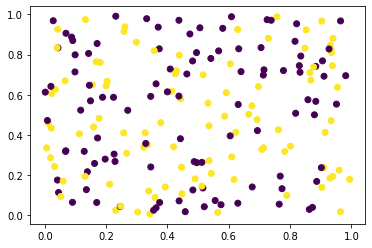

In [89]:
X, Y = binary_categories(length = 200)
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

In [12]:
X, Y = random_distribution()

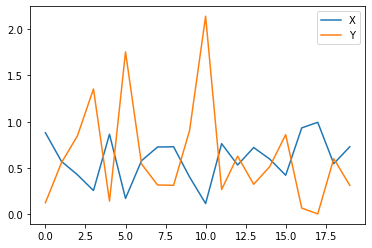

In [94]:
X, Y = functional_relationship(fun = lambda x: -1*np.log(x))
plt.plot(X)
plt.plot(Y)
plt.legend(['X', 'Y'])
plt.show()

In [95]:
# Initialise and train a neural network
architecture = [5, 5, 5, 5, 1]
fcnn = FCNN(architecture = architecture,
            learn_rates = [0.001 for n in range(len(architecture))],
            act_funcs = [leaky_relu if n < len(architecture)-1 else sigmoid for n in range(len(architecture))],
            nudge_limit = 1e-5, nudge_amount = 100,
            gradient_memories = [2 for n in range(len(architecture))],
            gradient_clips = [1 for n in range(len(architecture))],
            init_weight_scales = [(-0.5, 0.5) for n in range(len(architecture))])

fcnn.compile_net(X)
fcnn.train(100000, Y)

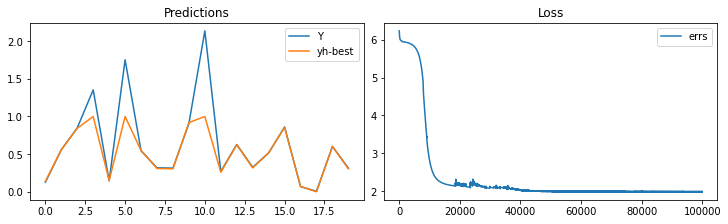

In [96]:
# Visualise predictions; and loss over epochs
fig, ax = plt.subplots(1, 2, figsize = (10, 3), constrained_layout = True)
ax[0] = fcnn.visualise_prediction(ax[0], Y)
ax[1] = fcnn.visualise_error(ax[1], 0)
plt.show()

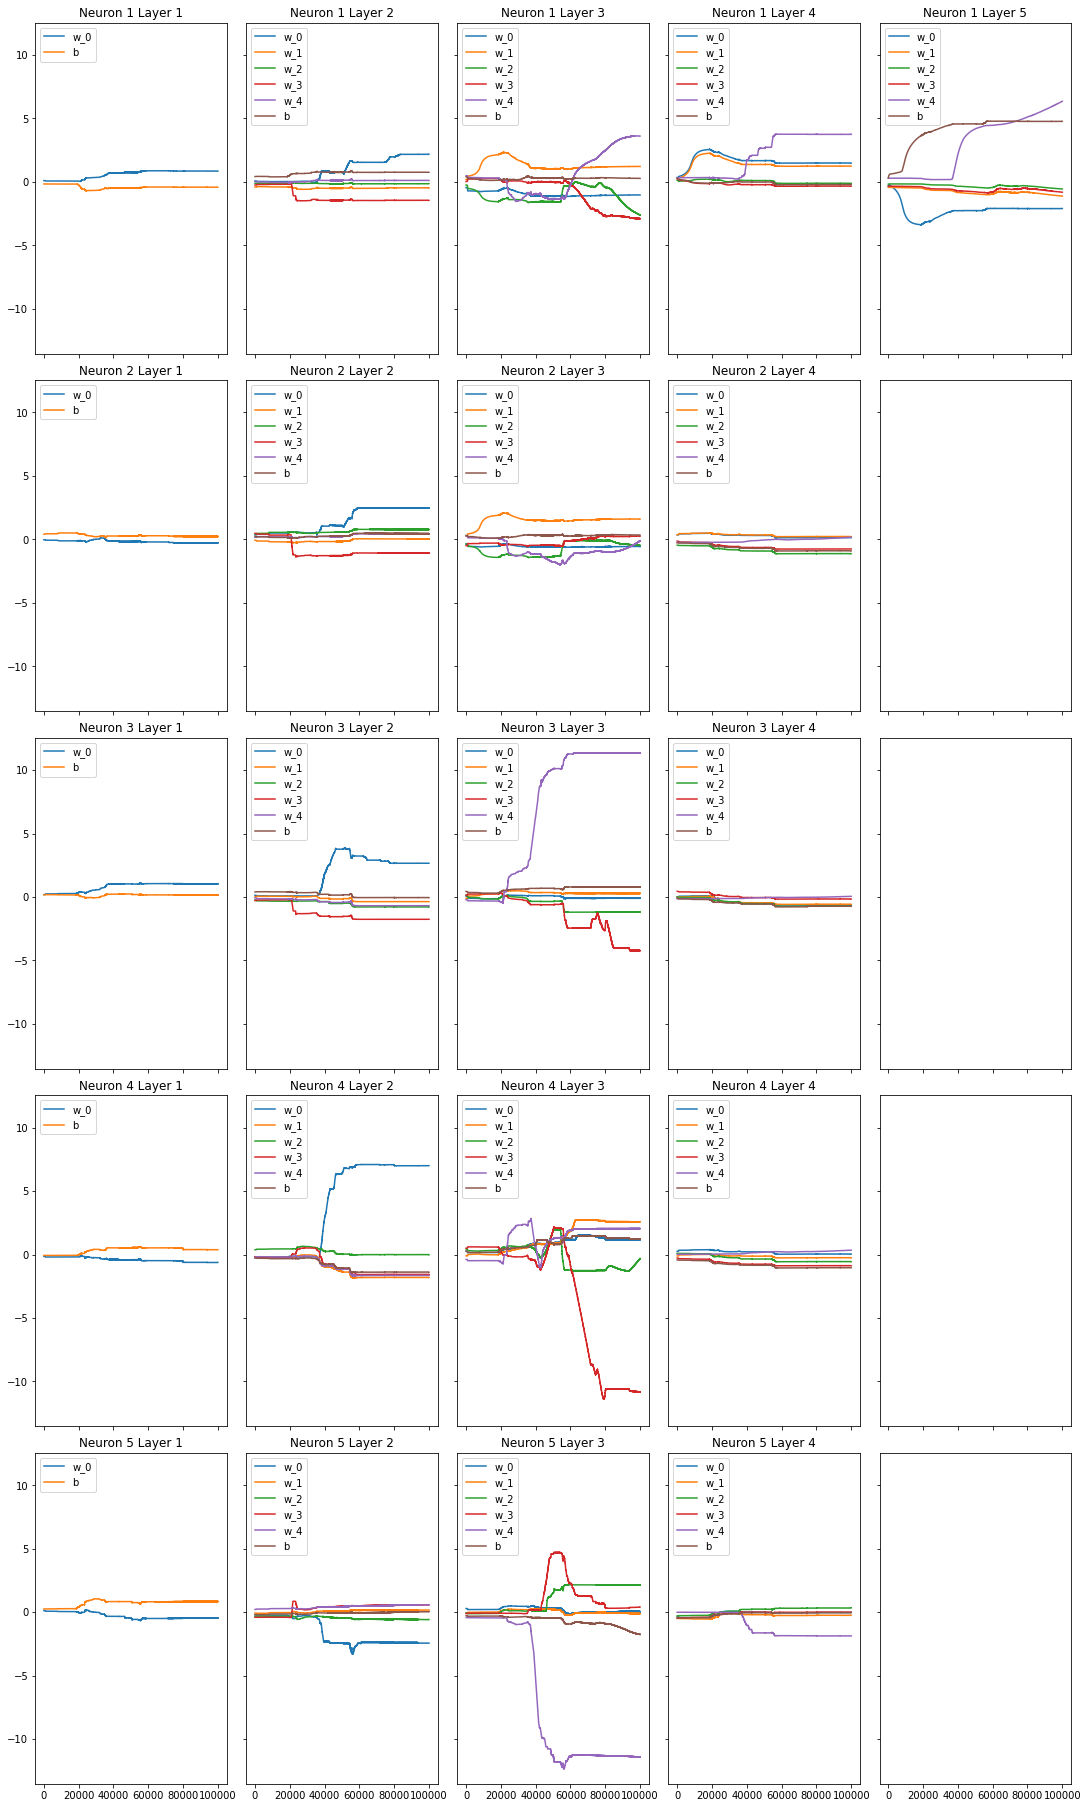

In [97]:
# Visualise weights over epochs
fcnn.visualise_weights()

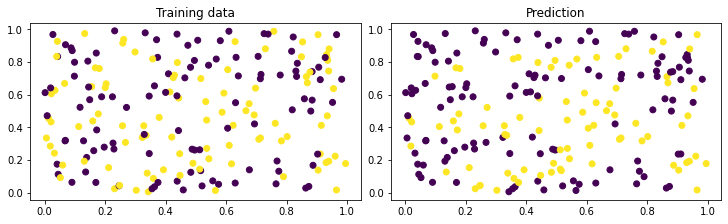

In [93]:
# Visualise training data with predictions as hue
fig, ax = plt.subplots(1, 2, figsize = (10, 3), constrained_layout = True)
ax[0].scatter(X[:,0], X[:,1], c=Y)
ax[0].set_title('Training data')
ax[1].scatter(X[:,0], X[:,1], c=[0 if y < 0.5 else 1 for y in fcnn.yhs[np.argmin(fcnn.errs)][0]])
ax[1].set_title('Prediction')
plt.show()